### <span style="color:red">Warning: Do not run notebook, certain cells take upwards of 30 minutes to run!!!</span>
# <span style="font-size:1.3em;">Beer Me: A Content-Based Recommender System
Author: Steven Addison

# Contents
<l></l>

<span style="font-size:1.2em;">

- <a href="#Overview">Overview</a>

- <a href="#Business Understanding">Business Understanding</a>  

- <a href="#Data Understanding">Data Understanding</a>  
    
- <a href="#Imports">Imports</a> 

- <a href="#Data Preparation & Analysis">Data Preparation & Analysis</a> 
    
    - <a href="#Creating Final Database">Creating Final Database</a>
    
    - <a href="#Text Preprocessing with Texthero">Text Preprocessing with Texthero</a>    
    
- <a href="#Modeling">Modeling</a>
    
    - <a href="#Cosine Similarity">Cosine Similarity</a>
    
    - <a href="#Linear Kernal">Linear Kernal</a>
    
    - <a href="#K-Nearest Neighbors">K-Nearest Neighbors</a>
        
- <a href="#Conclusion">Conclusion</a>
    
- <a href="#Next Steps">Next Steps</a>
    
- <a href="#Sources">Sources</a>

# <a id="#Overview">Overview</a>

> This project analyzes beer review data of 82,000 unique beers and recommends the top similar styles analyzing Review Text with a tf-idf vectorizer, Style, ABV, and Overall Rating.

# <a id="#Business Understanding">Business Understanding</a>

> As someone who has spent many years in the restaurant industry I often dread hearing “what do you recommend”, it always has felt like a loaded question to me seeing how one never has enough time to learn about a customer’s likes and taste in order to give accurate guidance. That is why a content-based recommender system such as this one can take all the guessing work out of the equation so that a customer can enjoy a beverage that has been selected for them based on similar items other enthusiasts have previously reviewed and enjoyed.

# <a id="Data Understanding">Data Understanding</a>

>

# <a id="Imports">Imports</a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import texthero as hero
from texthero import preprocessing
from texthero.visualization import wordcloud
from PIL import Image

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.neighbors import NearestNeighbors

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings

---
# <a id="Data Preparation & Analysis">Data Preparation & Analysis</a>

In [2]:
# import script used to preform basic EDA on my datasets, plus a dictionary used to define a later column
%run eda.py

---
> ### First Dataset
>
> [Beers, Breweries, and Beer Reviews](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv)

In [3]:
# Reading in the data containing the beers
beer = pd.read_csv('data/beers.csv')

In [4]:
# EDA on that data
# eda(beer)

In [5]:
# Dropping irrelevant columns
beer = beer.drop(columns=['country','notes'])

# Renaming columns for consistency among all dataframes
beer = beer.rename(columns={'id': 'beer_id', 'name': 'beer_name'})

# Removing rows without state data
beer = beer.dropna(subset=['state'])

# Cleaning the availability column 
beer['availability'] = beer['availability'].str.strip()

In [6]:
beer['broad_style'] = beer['style'].replace(styledict)

In [7]:
# eda(beer)

---
> ### Second Dataset
>
> [Beers, Breweries, and Beer Reviews](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv)

In [8]:
# Reading in the data containing the breweries
breweries = pd.read_csv('data/breweries.csv')

In [9]:
# EDA on that data
# eda(breweries)

In [10]:
# Dropping irrelevant columns
breweries = breweries.drop(columns=['notes'])

# Renaming columns for consistency among all dataframes
breweries = breweries.rename(columns={'id': 'brewery_id', 'name': 'brewery_name'})

# Removing rows without state data
beer = beer.dropna(subset=['state'])

---
> ### Third Dataset
>
> [Beers, Breweries, and Beer Reviews](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv)

In [12]:
# Reading in the data containg the breweries
reviews = pd.read_csv('data/reviews.csv')

In [13]:
# EDA on that data
# eda(reviews)

In [14]:
# Dropping irrelevant columns
reviews = reviews.drop(columns=['date','look','smell','taste','feel','overall'])

# Setting blank reviews as nan so they can be dropped
reviews['text'] = reviews['text'].str.strip()
reviews['text'] = reviews['text'].replace({"":np.nan,"0%":np.nan})

# Dropping reviews without username and review text data
reviews = reviews.dropna(subset=['username','text'])

---

## <a id="#Creating Final Database">Creating Final Database</a>

In [15]:
# Merging reviews into the beers bases on beer id
beer_reviews = beer.merge(reviews, on=['beer_id'])

In [17]:
# Merging breweries into the combined data
plus_brew = beer_reviews.merge(breweries, on=['brewery_id'])

In [19]:
# Dropping duplicate column
plus_brew = plus_brew.drop(columns=['state_x'])

# Renaming column to reflect
plus_brew = plus_brew.rename(columns={'state_y': 'state'})

In [20]:
# Selecting only available US beers
df = plus_brew.loc[(plus_brew['country'] == 'US') & (plus_brew['retired'] == 'f')]

# Dropping duplicates
df = df.drop_duplicates()

# Dropping rows with missing ibu data 
df = df.dropna(subset=['abv'])

# Sanity check of the data
df.head()

In [22]:
# Checking to see if some of these beers are actually named IPA and looking at each brewery's website I can confirm they are not creative people
df.loc[df['beer_name'] == 'IPA']

,beer_id,beer_name,brewery_id,style,availability,abv,retired,broad_style,username,text,score,brewery_name,city,state,country,types
87954,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,mjbachma,"Classic bottle and labeling, titled by style, ...",3.94,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
87955,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,CraftBeerRunner,Sweet Jammy fruity and bright. Drank fresh whi...,4.00,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
87956,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,Hopheadjeffery,Tasted in a Spiegelau IPA glass from a bottle ...,4.04,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
87957,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,BeerAndGasMasks,"From the bottle, it pours a nice lightly hazy ...",4.00,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
87958,91469,IPA,29573,American IPA,Year-round,7.2,f,India Pale Ale,NickSMpls,Can these guys do anything that's not great? O...,4.18,pFriem Family Brewers,Hood River,OR,US,"Brewery, Bar, Eatery, Beer-to-go"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2002145,202279,IPA,24952,American IPA,Rotating,6.5,f,India Pale Ale,kojevergas,On-draught at the bar in Sonoma. $5 per 16 oz ...,2.82,Hopmonk Tavern,Sonoma,CA,US,"Brewery, Bar, Eatery"
2002153,349972,IPA,49155,American IPA,Year-round,6.5,f,India Pale Ale,brett808ola,"Smells very fruity, great for tropical weather...",4.98,Hawaiian Ola Brewing Corporation,Kailua Kona,HI,US,"Brewery, Bar, Beer-to-go"
2002260,275547,IPA,48593,American IPA,Year-round,6.6,f,India Pale Ale,JacobusFavier23,L- Straw colored IPA with a slight amber tint....,3.66,Haint Blue Brewery,Mobile,AL,US,Brewery
2002326,322903,IPA,47202,American IPA,Year-round,5.9,f,India Pale Ale,stevoj,Bottle from BevMo. Gusher at opening. Dark gol...,3.55,Dagny Brewing Company,Modesto,CA,US,Brewery


In [23]:
# Creating a dataframe grouped by beer for content-based recommendations
cont_df = df.groupby(['beer_id'], as_index = False).agg({'text'' '.join, 'score':'mean','beer_id':'first',
                                                         'beer_name':'first','style':'first','broad_style':'first',
                                                         'abv':'first','brewery_name':'first','city':'first',
                                                         'state':'first'})

# Setting the index to beer's unique ID
cont_df = cont_df.set_index('beer_id')

# Sanity check of the data
cont_df.head()

## <a id="#Text Preprocessing with Texthero">Text Preprocessing with Texthero</a> 

[documentation](https://texthero.org/docs/api-preprocessing)

In [26]:
# Using Texthero's built in text cleaning pipeline
cont_df['clean_text'] = hero.clean(cont_df['text'])

In [28]:
# Stemming the text for modeling
cont_df['clean_text'] = hero.stem(cont_df['clean_text'])

In [64]:
# Dropping irelevant columns 
cont_df = cont_df.drop(columns=['text'])

KeyError: "['text' 'brewery_id' 'availability' 'retired'] not found in axis"

In [ ]:
# Sanity check of the data
cont_df.head()

In [32]:
# Saving off final cleaned dataset for use in the Streamlit App
# cont_df.to_csv('data/cont_df.csv', index_label = 'beer_id')

In [75]:
# Creating a vectorizer to transform the data with 300 features and a range of unigrams to trigrams
tf = TfidfVectorizer(max_features=300, ngram_range=(1,3))

# Fitting and transforming the clean text data 
dtm = tf.fit_transform(cont_df['clean_text'])

# Creating a document-term matrix
dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names(), index = cont_df.index)


KeyboardInterrupt


KeyboardInterrupt



In [ ]:
# Sanity check of the data
dtm.head()

# <a href="#Modeling">Modeling</a>

In [35]:
# Merging the document-term matrix back into the content dataframe
model_df = cont_df.merge(dtm, left_index=True, right_index=True)

# Renaming columns with the same name
model_df = model_df.rename(columns={'style_x':'style','abv_x':'abv'})

# Dropping irrelevant columns
model_df = model_df.drop(columns=['beer_id','style','beer_name','brewery_name','city','state','clean_text'])

In [39]:
# Creating a dataframe to call my results from
result_df = cont_df[['beer_name','style','brewery_name','city','state']]

# Making the column names pretty
result_df = result_df.rename(columns={'beer_name':'Name','style':'Style',
                                      'brewery_name':'Brewery','city':'City',
                                      'state':'State'})

In [42]:
# Encoding the styles for modeling
style_OHE = pd.get_dummies(model_df['broad_style'], sparse=True)

,Bière de Champagne / Bière Brut,Black Ale,Bock,Braggot,Brown Ale,California Common / Steam Beer,Chile Beer,Cream Ale,Dark Ale,Dark Lager,...,Porter,Pumpkin Beer,Russian Kvass,Rye Beer,Scottish Gruit / Ancient Herbed Ale,Smoke Beer,Stout,Strong Ale,Wheat Beer,Wild/Sour Beer
beer_id,,,,,,,,,,,,,,,,,,,,,
5,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:
# Calling the columns that need to be scaled
col_names = ['abv', 'score']

# Selecting those columns
features = model_df[col_names]

# Fitting and transforming the columns with a MinMaxScalers
features = MinMaxScaler().fit_transform(features.values)

# Setting those transformed features back into the data
model_df[col_names] = features

# Joining the one hot encoded data with the scaled data
final_df = model_df.join(style_OHE)

# Dropping the style column now that it is encoded out
final_df = final_df.drop(columns=['broad_style'])

In [74]:
# Sanity check
final_df.head()

,score,beer_id,abv,12oz,12oz bottl,abv_y,acid,actual,add,aftertast,...,Porter,Pumpkin Beer,Russian Kvass,Rye Beer,Scottish Gruit / Ancient Herbed Ale,Smoke Beer,Stout,Strong Ale,Wheat Beer,Wild/Sour Beer
beer_id,,,,,,,,,,,,,,,,,,,,,
5,0.599097,5,0.044522,0.024858,0.021963,0.007696,0.003840,0.016361,0.002976,0.031410,...,0,0,0,0,0,0,0,0,0,0
6,0.661612,6,0.055528,0.018583,0.017046,0.010297,0.003867,0.014326,0.006130,0.040365,...,0,0,0,0,0,0,0,0,0,0
7,0.560960,7,0.041521,0.022100,0.018015,0.011169,0.012991,0.031004,0.009680,0.035365,...,0,0,0,0,0,0,0,0,0,0
9,0.521956,9,0.041521,0.023273,0.017881,0.005543,0.000000,0.013320,0.013931,0.031104,...,0,0,0,0,0,0,0,0,0,0
10,0.698621,10,0.069535,0.015344,0.014025,0.027975,0.010790,0.010902,0.006651,0.036643,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# Superfuzz is the beer I will be testing
y = np.array(final_df.loc[90993])

# Reshaping the row into an array that can be passed into the model
y = y.reshape(1, -1)

# Calculating the cosine similarity 
cos_sim = cosine_similarity(final_df, y)

# Creating a printout of the scores with their respective indices
cos_sim = pd.DataFrame(data=cos_sim, index=final_df.index)

# Sorting by highest scoring
results = cos_sim.sort_values(by = 0, ascending=False)

# Printing out the source beer and its top 5 recommendations
results.head(6)

,0
beer_id,
90993,1.0
80348,1.0
113339,1.0
98663,1.0
110744,1.0
91358,1.0


In [60]:
# This is the printout for my starting beer
result_df.loc[90993]

Name       Superfuzz Blood Orange Pale Ale
Style              American Pale Ale (APA)
Brewery            Elysian Brewing Company
City                               Seattle
State                                   WA
Name: 90993, dtype: object

In [61]:
# And the printout of my top result
result_df.loc[80348]

Name         Blood Orange Pale Ale
Style      American Pale Ale (APA)
Brewery    Great South Bay Brewery
City                     Bay Shore
State                           NY
Name: 80348, dtype: object

## <a id="#Cosine Similarity">Cosine Similarity</a>

In [66]:
def cos_beer():
    
    """Returns top recommended beers based on cosine similarity with user imputs of style,
    beer name, and number of recommendations"""
    
    # User inputs style of beer they are looking for
    style_input = input('Style: ')
    # Input name of beer
    beer_input = input('Beer Name: ')
    # Input number of recommendations
    n_recs = int(input('How many recommendations? '))
    
    # Data is sliced 
    style_df = cont_df[cont_df['broad_style'] == style_input]
    
    # Creating a vectorizer to transform the data with 300 features and a range of unigrams to trigrams
    tf = TfidfVectorizer(max_features=300, ngram_range=(1,3))
    # Fitting and transforming the clean text data 
    dtm = tf.fit_transform(style_df['clean_text'])
    # Creating a document-term matrix
    dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names(), index = style_df.index)
    # Merging the document-term matrix back into the content dataframe
    style_df = style_df.merge(dtm, left_index=True, right_index=True)
    # Renaming columns with the same name
    style_df = style_df.rename(columns={'style_x':'style','abv_x':'abv'})
    # Dropping irrelevant columns
    style_df = style_df.drop(columns=['broad_style','style','beer_name','brewery_name',
                                      'city','state','clean_text'])

    # Calling the columns that need to be scaled
    col_names = ['abv', 'score']
    # Selecting those column
    features = style_df[col_names]
    # Fitting and transforming the columns with a MinMaxScalers
    features = MinMaxScaler().fit_transform(features.values)
    # Setting those transformed features back into the data
    style_df[col_names] = features
    
    # Grabbing the index value of the inputed beer
    beerix = cont_df.loc[cont_df['beer_name'] == beer_input].index.values
    # Selecting the row of that beer
    y = np.array(style_df.loc[beerix[0]])
    # Reshaping the row into an array that can be passed into the model
    y = y.reshape(1, -1)
    
    # Calculating the cosine similarity 
    cos_sim = cosine_similarity(style_df, y)
    # Creating a printout of the scores with their respective indices
    cos_sim = pd.DataFrame(data=cos_sim, index=style_df.index)
    # Sorting by highest scoring
    results = cos_sim.sort_values(by = 0, ascending=False)
    # Selecting n number indicies of top recommendations
    nresultsid = results.head(n_recs+1).index.values[1:]
    # Locating those beers in my results dataframe
    nresults_df = result_df.loc[nresultsid]
    # Returning those results
    return nresults_df.style.hide_index()

In [67]:
# Testing the function
cos_beer()

Style: Pale Ale
Beer Name: Superfuzz Blood Orange Pale Ale
How many recommendations? 5


Name,Style,Brewery,City,State
CitruSinensis (OneHitter Series),American Pale Ale (APA),Lagunitas Brewing Company,Petaluma,CA
Blood Orange Pale Ale,American Pale Ale (APA),Great South Bay Brewery,Bay Shore,NY
X - Orange,American Pale Ale (APA),AleSmith Brewing Company,San Diego,CA
Naranjito,American Pale Ale (APA),Brooklyn Brewery,Brooklyn,NY
Rain In Blood Orange Pale Ale,American Pale Ale (APA),Dark Horse Brewing Company,Marshall,MI


## <a id="#Linear Kernal">Linear Kernal</a>

In [69]:
def lin_beer():
    
    """Returns top recommended beers based on linear kernel with user imputs of style,
    beer name, and number of recommendations"""
    
    # User inputs style of beer they are looking for
    style_input = input('Style: ')
    # Input name of beer
    beer_input = input('Beer Name: ')
    # Input number of recommendations
    n_recs = int(input('How many recommendations? '))
    
    # Data is sliced 
    style_df = cont_df[cont_df['broad_style'] == style_input]
    
    # Creating a vectorizer to transform the data with 300 features and a range of unigrams to trigrams
    tf = TfidfVectorizer(max_features=300, ngram_range=(1,3))
    # Fitting and transforming the clean text data 
    dtm = tf.fit_transform(style_df['clean_text'])
    # Creating a document-term matrix
    dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names(), index = style_df.index)
    # Merging the document-term matrix back into the content dataframe
    style_df = style_df.merge(dtm, left_index=True, right_index=True)
    # Renaming columns with the same name
    style_df = style_df.rename(columns={'style_x':'style','abv_x':'abv'})
    # Dropping irrelevant columns
    style_df = style_df.drop(columns=['broad_style','style','beer_name','brewery_name',
                                      'city','state','clean_text'])

    # Calling the columns that need to be scaled
    col_names = ['abv', 'score']
    # Selecting those column
    features = style_df[col_names]
    # Fitting and transforming the columns with a MinMaxScalers
    features = MinMaxScaler().fit_transform(features.values)
    # Setting those transformed features back into the data
    style_df[col_names] = features
    
    # Grabbing the index value of the inputed beer
    beerix = cont_df.loc[cont_df['beer_name'] == beer_input].index.values
    # Selecting the row of that beer
    y = np.array(style_df.loc[beerix[0]])
    # Reshaping the row into an array that can be passed into the model
    y = y.reshape(1, -1)
    
    # Calculating the linear kernel 
    lin_ker = linear_kernel(style_df, y)
    # Creating a printout of the scores with their respective indices
    lin_ker = pd.DataFrame(data=lin_ker, index=style_df.index)
    # Sorting by highest scoring
    results = lin_ker.sort_values(by = 0, ascending=False)
    # Selecting n number indicies of top recommendations
    nresultsid = results.head(n_recs+1).index.values[1:]
    # Locating those beers in my results dataframe
    nresults_df = result_df.loc[nresultsid]
    # Returning those results
    return nresults_df.style.hide_index()

In [70]:
# Testing the function
lin_beer()

Style: Pale Ale
Beer Name: Superfuzz Blood Orange Pale Ale
How many recommendations? 5


Name,Style,Brewery,City,State
Superfuzz Blood Orange Pale Ale,American Pale Ale (APA),Elysian Brewing Company,Seattle,WA
Mosaic Dry Hopped Fort Point,American Pale Ale (APA),Trillium Brewing Company,Boston,MA
Pseudo Sue - Double Dry-Hopped,American Pale Ale (APA),Toppling Goliath Brewing Company,Decorah,IA
Hall Of Fame: .394 Imperial San Diego Pale Ale,American Pale Ale (APA),AleSmith Brewing Company,San Diego,CA
Dreamsicle,American Pale Ale (APA),Pipeworks Brewing Company,Chicago,IL


## <a id="#K-Nearest Neighbors">K-Nearest Neighbors</a>

In [71]:
def knn_beer():
    
    """Returns top recommended beers using K-Nearest Neighbors with user imputs of style,
    beer name, and number of recommendations"""
    
    # User inputs style of beer they are looking for
    style_input = input('Style: ')
    # Input name of beer
    beer_input = input('Beer Name: ')
    # Input number of recommendations
    n_recs = int(input('How many recommendations? '))
    
    # Data is sliced 
    style_df = cont_df[cont_df['broad_style'] == style_input]
    
    # Creating a vectorizer to transform the data with 300 features and a range of unigrams to trigrams
    tf = TfidfVectorizer(max_features=300, ngram_range=(1,3))
    # Fitting and transforming the clean text data 
    dtm = tf.fit_transform(style_df['clean_text'])
    # Creating a document-term matrix
    dtm = pd.DataFrame(dtm.todense(), columns=tf.get_feature_names(), index = style_df.index)
    # Merging the document-term matrix back into the content dataframe
    style_df = style_df.merge(dtm, left_index=True, right_index=True)
    # Renaming columns with the same name
    style_df = style_df.rename(columns={'style_x':'style','abv_x':'abv'})
    # Dropping irrelevant columns
    style_df = style_df.drop(columns=['broad_style','style','beer_name','brewery_name',
                                      'city','state','clean_text'])

    # Calling the columns that need to be scaled
    col_names = ['abv', 'score']
    # Selecting those column
    features = style_df[col_names]
    # Fitting and transforming the columns with a MinMaxScalers
    features = MinMaxScaler().fit_transform(features.values)
    # Setting those transformed features back into the data
    style_df[col_names] = features
    
    # Grabbing the index value of the inputed beer
    beerix = cont_df.loc[cont_df['beer_name'] == beer_input].index.values
    # Selecting the row of that beer
    x = np.array(style_df.loc[beerix[0]])
    # Reshaping the row into an array that can be passed into the model
    x = y.reshape(1, -1)
    
    # Creating a knn model with the auto algorithm and 5 nearest neighbors
    knn = NearestNeighbors(algorithm='auto', n_neighbors=5)
    # Fitting the model on the dataframe
    knn.fit(style_df)
    
    # Selecting n number results
    results = knn.kneighbors(x, n_recs+1, return_distance=False).flatten()
    # Selecting their indicies
    resultsids = style_df.iloc[results].index.values[1:]
    # Locating those beers in my results dataframe
    nresults_df = result_df.loc[resultsids]
    # Returning those results
    return nresults_df.style.hide_index()

In [72]:
# Testing the function
knn_beer()

Style: Pale Ale
Beer Name: Superfuzz Blood Orange Pale Ale
How many recommendations? 5


Name,Style,Brewery,City,State
CitruSinensis (OneHitter Series),American Pale Ale (APA),Lagunitas Brewing Company,Petaluma,CA
Blood Orange Pale Ale,American Pale Ale (APA),Great South Bay Brewery,Bay Shore,NY
X - Orange,American Pale Ale (APA),AleSmith Brewing Company,San Diego,CA
Naranjito,American Pale Ale (APA),Brooklyn Brewery,Brooklyn,NY
Rain In Blood Orange Pale Ale,American Pale Ale (APA),Dark Horse Brewing Company,Marshall,MI


# <a id="#Conclusion">Conclusion</a>

>

In [78]:
# Importing mask for the shape of my word clouds
beer_mask = np.array(Image.open('images/beershape.png'))

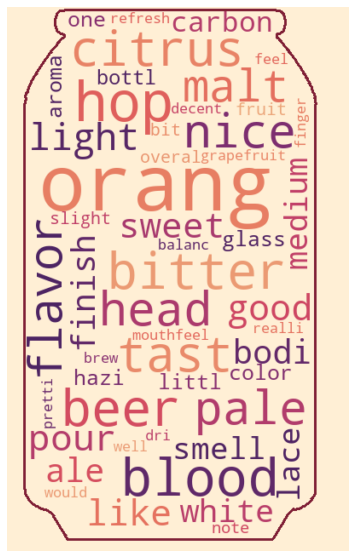

In [141]:
# Creating cloud for my reference beer
beer1 = cont_df.loc[[90993]]['clean_text']
wordcloud(beer1, max_words = 50, mask=beer_mask, contour_color='#802036', contour_width=2, colormap = 'flare', height= 600)

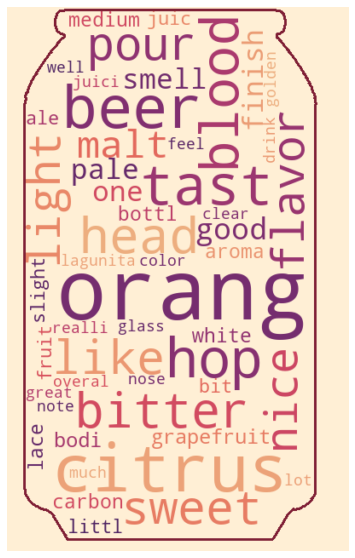

In [139]:
# Creating cloud for my top recommendation
beer2 = cont_df.loc[[175577]]['clean_text']
wordcloud(beer2, max_words = 50, mask=beer_mask, contour_color='#802036', contour_width=2, colormap = 'flare', height= 600)

# <a id="#Next Steps">Next Steps</a>   

>

# <a id="#Sources">Sources</a>

> [Beers, Breweries, and Beer Reviews](https://www.kaggle.com/ehallmar/beers-breweries-and-beer-reviews?select=beers.csv)
>
> [Texthero](https://texthero.org/)
>
> [How to Create Beautiful Word Clouds in Python](https://towardsdatascience.com/how-to-create-beautiful-word-clouds-in-python-cfcf85141214)